# ♻️ OBJECT DETECTION USING YOLOv8 ON CUSTOM WASTE BANK DATASET ♻️
The goal of this project is to utilize the YOLOv8 model for object detection to accurately identify and classify waste materials sorted at a waste bank, leveraging a custom dataset to enhance sorting accuracy and operational efficiency.
Overview of the workflow
1. Set up the notebook (jupyter) with paperspace A4000 machine
2. YOLOv8 Dependency Installation
3. Get custom dataset from git wasteapp repo
4. Visualize the train images with their bounding boxes
5. Train the custom waste bank dataset
6. Validation the model taht has been trained
7. Test and Run inference with the custom YOLOv8s Object Detection Trained Weight
8. Visualize the prediction by plotting validation images (test images) and their predicted bounding boxes

**Import the neccesary library**

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 8.8 MB/s eta 0:00:00a 0:00:01


In [1]:
import ultralytics

print(ultralytics.__version__)

8.2.48


In [24]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 60.8 MB/s eta 0:00:00:00:0100:01


In [13]:
!pip install matplotlib

In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import random
import os
from ultralytics import YOLO
from PIL import Image

# Dataset

the dataset gathered 30% new images + 70% images collected from websites and annotated using roboflow, 
then split to train(70%), valid(20%), and test(10%)

The dataset has 3 folders:

train - contains ---- images.

valid - contains --- images. Care has been taken to prevent any data leakage. Any image present in the train set is not a part of the val set.

test - contains --- images.

Hence, effort has been made to create a good quality dataset because the quality of the predictions depends a lot on the quality of the dataset the model has been trained on.
Structure of the dataset:

number of classes in the dataset = 14

names: [‘Botol Kaca’, ‘Botol Plastik’, ‘Galon’, ‘Gelas Plastik’, ‘Kaleng’, ‘Kantong Plastik’, ‘Kantong Semen’, ‘Kardus’, ‘Kemasan Plastik’, ‘Kertas Bekas’, ‘Koran’, ‘Pecahan Kaca’, ‘Toples Kaca’, ‘Tutup Galon’]

dataset

|__ train

—-|______ images

—-|______ labels

|__ valid

—-|______ images

—-|______ labels

|__ test

—-|______ images

—-|______ labels


In [4]:
!git clone https://github.com/wastebank-project/machine_learning.git
#Loaded dataset from github

Cloning into 'machine_learning'...
remote: Enumerating objects: 10423, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10423 (delta 0), reused 5 (delta 0), pack-reused 10415
Receiving objects: 100% (10423/10423), 231.01 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (18881/18881), done.


**CHECKING ISSUE IN DATASET**

In [3]:
def verify_dataset(base_path):
    subsets = ['train', 'valid', 'test']
    issues = []

    for subset in subsets:
        images_path = os.path.join(base_path, subset, 'images')
        labels_path = os.path.join(base_path, subset, 'labels')

        # Collect all image and label files
        image_files = {file for file in os.listdir(images_path) if file.endswith('.jpg')}
        label_files = {file.replace('.txt', '.jpg') for file in os.listdir(labels_path) if file.endswith('.txt')}

        # Check for missing label or image files
        missing_labels = image_files - label_files
        missing_images = label_files - image_files

        if missing_labels:
            issues.append(f'Missing labels in {subset}: {missing_labels}')
        if missing_images:
            issues.append(f'Missing images in {subset}: {missing_images}')

        # Verify image integrity
        for image_file in image_files:
            image_path = os.path.join(images_path, image_file)
            try:
                img = cv2.imread(image_path)
                if img is None:
                    raise ValueError("Cannot read the image file.")
            except Exception as e:
                issues.append(f'Corrupt image file {image_path}: {str(e)}')

    return issues

base_path = '/notebooks/dataset.yolo'

dataset_issues = verify_dataset(base_path)
if dataset_issues:
    for issue in dataset_issues:
        print(issue)
else:
    print("No issues found with the dataset.")

No issues found with the dataset.


**VISUALIZE IMAGES AND BBOX**

In [3]:
def yolo2bbox(bboxes):

    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [4]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

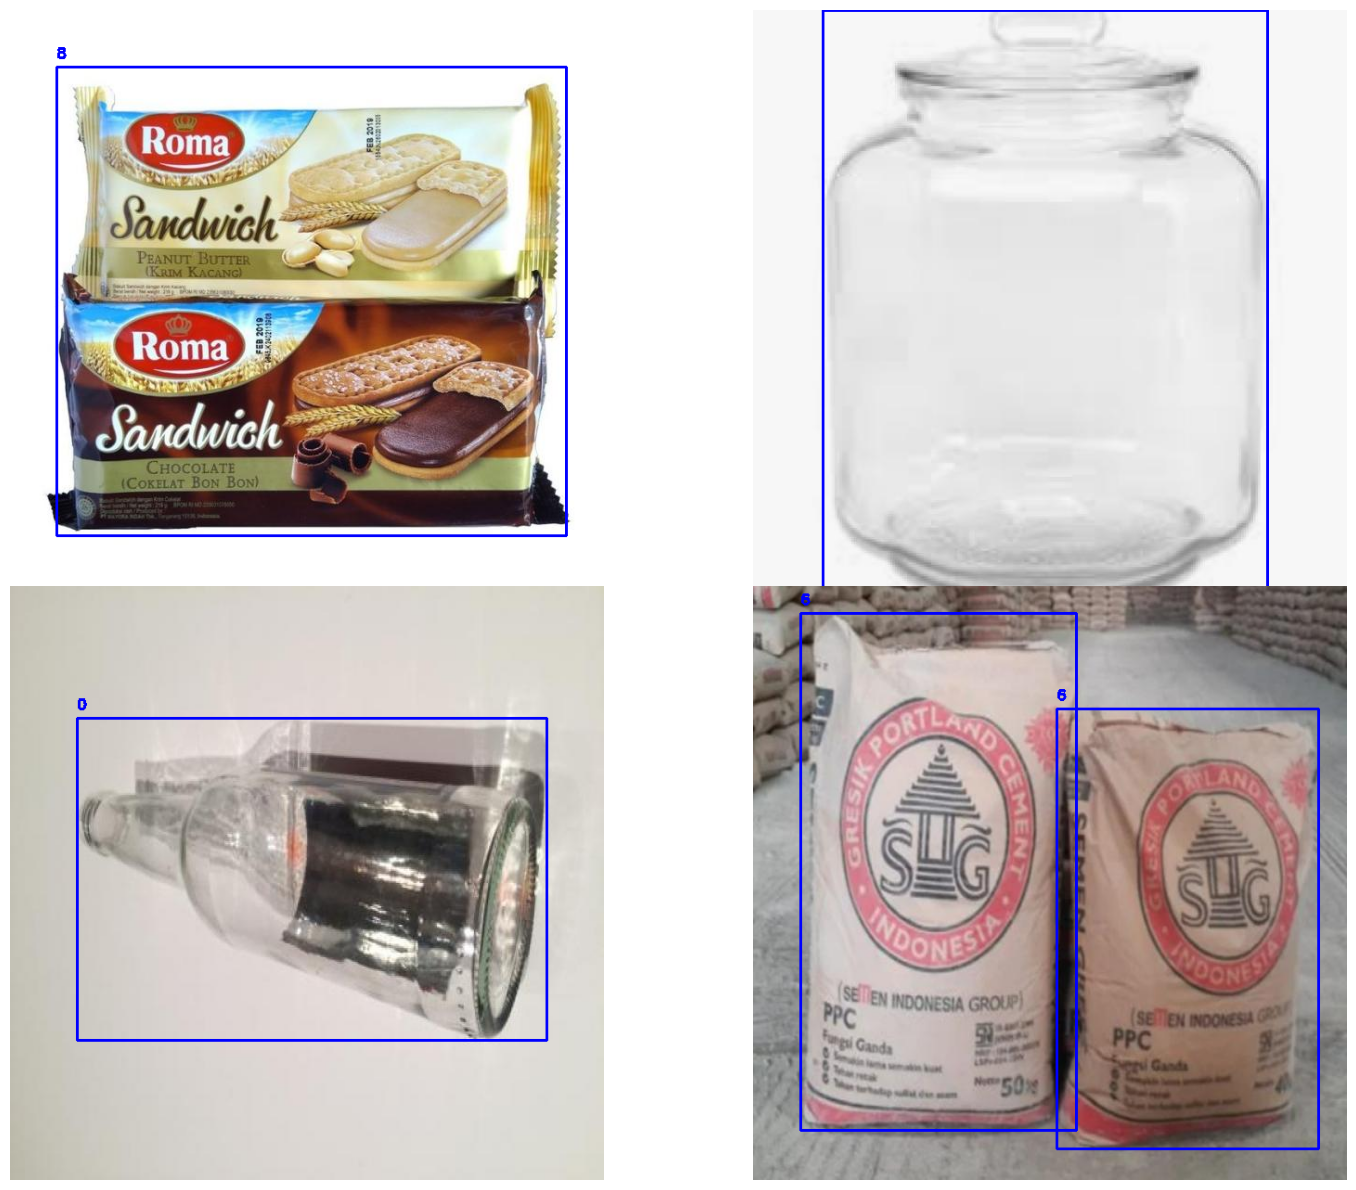

In [5]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image
#%%
def plot_box(image, bboxes, labels):
    """
    Draws bounding boxes and labels on the image.
    """
    for (x_c, y_c, w, h), label in zip(bboxes, labels):
        # Convert from center coordinates to corner coordinates
        x1 = int((x_c - w / 2) * image.shape[1])
        y1 = int((y_c - h / 2) * image.shape[0])
        x2 = int((x_c + w / 2) * image.shape[1])
        y2 = int((y_c + h / 2) * image.shape[0])

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Place the label
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return image

def plot(image_paths, label_paths, num_samples):
    all_images = glob.glob(os.path.join(image_paths, '*.jpg')) + glob.glob(os.path.join(image_paths, '*.JPG'))
    all_images.sort()

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        idx = random.randint(0, len(all_images) - 1)
        image_path = all_images[idx]
        label_path = os.path.join(label_paths, os.path.basename(image_path).replace('.jpg', '.txt').replace('.JPG', '.txt'))

        image = cv2.imread(image_path)
        bboxes = []
        labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    label = parts[0]
                    x_c, y_c, w, h = map(float, parts[1:])
                    bboxes.append([x_c, y_c, w, h])
                    labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')

    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

# visualize a few training images
plot(
    image_paths='/notebooks/dataset.yolo/train/images',
    label_paths='/notebooks/dataset.yolo/train/labels',
    num_samples=4
)

# TRAIN YOLOv8s MODEL ON CUSTOM DATASET

**BATCH 16**

In [11]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=100,
    batch=16,
    lr0=0.0001,
    lrf=0.0001,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e100_lr0.0001'
)

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e100_lr0.0001, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e100_lr0.0001/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e100_lr0.0001
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.33G     0.8818      2.939      1.363         53        640: 100%|██████████| 122/122 [00:18<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.278      0.348      0.275      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.46G     0.7792      1.922      1.282         37        640: 100%|██████████| 122/122 [00:17<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]

                   all        564        877      0.573      0.547      0.586      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.45G     0.7417      1.622      1.247         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877       0.62        0.6      0.649      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G     0.6976      1.433      1.207         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877       0.64      0.676       0.71      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G     0.6975      1.331      1.217         64        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]

                   all        564        877      0.657      0.705      0.736       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G     0.6779      1.199      1.197         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.779      0.639      0.754      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G     0.6721      1.139      1.181         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.773      0.693      0.762      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.43G     0.6582        1.1      1.186         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.764      0.686      0.755      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G     0.6533      1.065      1.178         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.746      0.717      0.788      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G     0.6481      1.018      1.167         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.749      0.725      0.784      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.42G     0.6317     0.9953      1.154         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.772       0.71      0.781      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.42G     0.6219     0.9452      1.153         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.771      0.708      0.793      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G     0.6259     0.9355      1.153         80        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]

                   all        564        877      0.777      0.722      0.788      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G     0.6217     0.8921      1.153         58        640: 100%|██████████| 122/122 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]

                   all        564        877      0.777      0.714      0.785      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.43G      0.605     0.8634      1.145         42        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]

                   all        564        877      0.781      0.741      0.801       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G     0.5968     0.8348      1.134         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.763      0.741      0.792      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G     0.6037     0.8173      1.143         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]

                   all        564        877      0.748      0.717      0.763      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.5939     0.7993      1.122         49        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.738      0.762      0.797      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.43G     0.5856     0.7688      1.123         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.747      0.741      0.791      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.43G     0.5706     0.7555      1.113         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.782       0.74      0.805      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.43G     0.5809     0.7474      1.125         38        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]

                   all        564        877       0.77      0.742      0.788      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.43G     0.5817     0.7544      1.116         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.778      0.722      0.777      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.43G     0.5805     0.7399       1.12         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]

                   all        564        877      0.805      0.725      0.806      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.43G     0.5769     0.7195      1.114         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.767      0.745      0.788      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.43G     0.5509     0.6815      1.095         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.798       0.73      0.811      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.43G     0.5614     0.7007      1.101         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.789      0.751      0.819      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G     0.5611     0.6788      1.104         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.805      0.749      0.817      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.43G     0.5576     0.6739      1.099         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.795      0.747      0.806      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.43G     0.5473      0.674      1.093         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]

                   all        564        877      0.779      0.731      0.809      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.43G     0.5538     0.6655      1.096         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.772      0.781      0.816      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.42G      0.551     0.6511      1.097         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.774      0.747       0.81      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.43G     0.5356     0.6122      1.083         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.795      0.743      0.809      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.43G     0.5411     0.6204      1.084         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.798      0.751      0.823      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.43G      0.534     0.6141      1.085         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.816      0.748      0.823      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.43G     0.5307     0.6084       1.08         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.784      0.747      0.815      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.44G     0.5325       0.61       1.08         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.825      0.747      0.812      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.42G     0.5276     0.6027      1.082         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.796      0.778      0.815      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.43G     0.5201     0.5795      1.074         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.784      0.762      0.815      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.43G     0.5178     0.5734      1.074         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.801      0.778      0.816      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.44G     0.5215     0.5796      1.071         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.817      0.747      0.802      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.43G     0.5236     0.5834      1.082         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.802      0.763      0.813      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.43G     0.5105     0.5545      1.066         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.789      0.761      0.818      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.43G     0.5132     0.5478      1.069         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.785      0.754      0.802      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.43G     0.5176     0.5531      1.073         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.807      0.747      0.818      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.42G     0.5147     0.5487      1.061         70        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.798      0.774      0.809        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.43G     0.4987     0.5229      1.059         40        640: 100%|██████████| 122/122 [00:17<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.815      0.755      0.808      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.43G     0.5099     0.5354      1.063         44        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.806      0.763      0.811      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.44G     0.5012     0.5221      1.065         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877        0.8      0.767      0.811      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.43G     0.5008      0.516      1.065         41        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.804      0.786      0.817      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.43G     0.4977     0.5205      1.059         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.818      0.775      0.814      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.43G     0.4938     0.5165      1.054         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.35it/s]

                   all        564        877      0.812      0.738      0.802      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.43G     0.4924     0.5107      1.055         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.786      0.745      0.805      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.42G      0.496     0.5147      1.058         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.796      0.748      0.811      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.42G      0.497     0.4964      1.057         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877        0.8      0.779      0.824      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.44G     0.4825     0.4865      1.049         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.818      0.752      0.818      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.43G     0.4953     0.5029      1.055         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.795      0.776      0.815      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.43G     0.4765     0.4748      1.043         39        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.788       0.76      0.805      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.43G     0.4829     0.5008      1.044         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.816      0.765       0.81      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.43G     0.4766      0.473      1.048         75        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.824      0.763      0.823      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.43G     0.4713     0.4648      1.038         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.845      0.752      0.819      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.43G     0.4764     0.4767       1.04         57        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.828      0.752      0.815      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.43G      0.471     0.4662      1.039         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.836      0.748      0.814      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.44G     0.4657     0.4545      1.035         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.829      0.768      0.818       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.43G     0.4732     0.4647       1.04         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.832      0.754      0.815      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.43G     0.4692     0.4705      1.043         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.825      0.773       0.82      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.42G     0.4579     0.4502      1.035         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]

                   all        564        877      0.859      0.734      0.825      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.44G     0.4642     0.4598      1.034         63        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877       0.82      0.781      0.826       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.43G     0.4597     0.4491      1.036         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877       0.83      0.754      0.815      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.43G     0.4625     0.4498      1.029         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]

                   all        564        877      0.801      0.781       0.82      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.43G     0.4537     0.4405      1.029         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.795      0.786      0.817      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.43G     0.4464     0.4302      1.025         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.826      0.756      0.819      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.43G     0.4574     0.4425      1.036         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.773        0.8      0.809      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.43G     0.4513     0.4395      1.032         83        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.805      0.774      0.814      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.43G     0.4495     0.4366      1.031         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.35it/s]

                   all        564        877       0.81      0.784      0.821      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.43G     0.4385     0.4308      1.021         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877       0.82      0.778      0.824      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.43G     0.4552     0.4325      1.028         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.813      0.784      0.825      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.43G     0.4517      0.433      1.026         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.802        0.8      0.829      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.43G     0.4464     0.4317      1.022         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.814       0.78      0.823      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.43G     0.4382     0.4208      1.016         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]

                   all        564        877      0.802        0.8      0.823      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.42G     0.4326      0.408      1.016         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.853      0.762       0.83      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.43G     0.4398     0.4115      1.026         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.817      0.779      0.823      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.43G     0.4494     0.4125      1.029         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]

                   all        564        877      0.829      0.782      0.824      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.44G     0.4412     0.4167      1.025         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.805      0.798      0.824      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.43G     0.4406     0.4076      1.018         43        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.821      0.771      0.825      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.42G     0.4271      0.404      1.018         44        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.824      0.778      0.829      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.43G     0.4298     0.4071      1.015         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.839      0.757      0.827      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.44G     0.4307     0.4047      1.013         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.838      0.755      0.819       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.43G     0.4368     0.4077      1.023         57        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.833      0.766      0.824      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.42G     0.4205     0.3899       1.01         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]

                   all        564        877      0.806      0.788      0.824      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.43G     0.4227     0.3965      1.014         61        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.825      0.771      0.827      0.729


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.43G     0.3497     0.3298     0.9643         20        640: 100%|██████████| 122/122 [00:17<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.823      0.752       0.81       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.43G     0.3365     0.3074     0.9584         34        640: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.795      0.785      0.814      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.43G     0.3297     0.2903     0.9518         31        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.832      0.758      0.817      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.43G       0.32     0.2826     0.9413         32        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.23it/s]

                   all        564        877      0.835      0.763      0.824      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.43G     0.3252     0.2776      0.944         30        640: 100%|██████████| 122/122 [00:16<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.823      0.761       0.82       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.43G     0.3196     0.2748     0.9437         25        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.817      0.768      0.823      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.44G     0.3182     0.2782     0.9481         22        640: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877       0.82      0.769      0.822      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.42G     0.3187     0.2676     0.9412         30        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.802      0.792      0.824      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.43G     0.3208     0.2821     0.9374         35        640: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.35it/s]

                   all        564        877      0.808      0.783      0.823      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.43G     0.3204     0.2735     0.9474         22        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]

                   all        564        877      0.812      0.784      0.824      0.724



100 epochs completed in 0.562 hours.
Optimizer stripped from runs/detect/yolov8s_e100_lr0.0001/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e100_lr0.0001/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e100_lr0.0001/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


                   all        564        877      0.825      0.772      0.827      0.729
             BotolKaca         40         40      0.856        0.9      0.907      0.843
          BotolPlastik         45         47      0.803      0.868      0.857      0.809
                 Galon         44         62      0.878      0.726      0.804      0.721
          GelasPlastik         40         87      0.837      0.632      0.791      0.672
                Kaleng         40         62      0.916       0.88      0.977      0.938
        KantongPlastik         41         46      0.957      0.978      0.984      0.901
          KantongSemen         40         56      0.837      0.736      0.834      0.692
                Kardus         40         79      0.624      0.696      0.653      0.543
        KemasanPlastik         40         69      0.867      0.663      0.777      0.641
           KertasBekas         40         66      0.786      0.667      0.774      0.703
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7ba8df0090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [12]:
model_path = '/notebooks/runs/detect/yolov8s_e100_lr0.0001/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_e100_lr0.0001.txt') 

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.64it/s]


                   all        564        877      0.824      0.771      0.825      0.729
             BotolKaca         40         40      0.857        0.9      0.908      0.844
          BotolPlastik         45         47      0.803      0.867      0.858      0.809
                 Galon         44         62      0.879      0.726      0.803      0.721
          GelasPlastik         40         87      0.848       0.64      0.792      0.673
                Kaleng         40         62      0.916      0.879      0.977      0.937
        KantongPlastik         41         46      0.957      0.978      0.984      0.901
          KantongSemen         40         56      0.837      0.733      0.833      0.692
                Kardus         40         79      0.626      0.684       0.65       0.54
        KemasanPlastik         40         69      0.867      0.663      0.777      0.641
           KertasBekas         40         66      0.789      0.678      0.774      0.701
                 Kora

**BATCH 32**

In [7]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=100,
    batch=32,
    lr0=0.0001,
    lrf=0.0001,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e100_lr0.0001_32'
)

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e100_lr0.0001_32, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e100_lr0.0001_32/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e100_lr0.0001_32
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.41G     0.8618      3.376      1.358        110        640: 100%|██████████| 61/61 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        564        877      0.282      0.167      0.132     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.33G     0.7701      1.914      1.276        150        640: 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.553      0.521      0.553       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.46G     0.7368      1.573      1.233        140        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.661      0.605      0.676      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.41G     0.6974      1.325      1.203        122        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        564        877      0.692      0.618       0.69      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.46G     0.6818       1.25      1.201        121        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        564        877      0.703      0.619      0.688      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.41G     0.6611      1.143      1.184        114        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        564        877      0.709      0.684      0.746      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.46G     0.6451      1.079      1.161         96        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        564        877      0.718      0.653      0.728      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.48G     0.6374      1.018      1.163        102        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.743      0.665      0.766      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.33G     0.6155     0.9521      1.145        128        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877       0.76        0.7      0.784      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.48G      0.617     0.9103      1.153        149        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        564        877      0.759      0.711      0.786      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.33G     0.6111     0.8916      1.142        105        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.755      0.697      0.769      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.48G     0.5891     0.8339      1.126        119        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        564        877      0.772      0.714       0.79       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.33G     0.6042     0.8375      1.139         94        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        564        877        0.8      0.698      0.793       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.48G     0.5943     0.7989      1.128        116        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        564        877      0.755      0.715      0.795      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.46G      0.589     0.7873      1.127        114        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        564        877      0.801      0.728      0.806      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.35G     0.5964      0.761      1.122        114        640: 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.798        0.7       0.78      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.46G     0.5891     0.7496      1.121        112        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        564        877      0.807       0.73      0.807      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.52G     0.5861     0.7244      1.113         95        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.777      0.742      0.788      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.46G     0.5702     0.7172      1.115        121        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.816      0.708      0.807       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.47G     0.5658     0.6924      1.101        103        640: 100%|██████████| 61/61 [00:15<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877      0.768      0.723      0.787      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.47G     0.5617     0.6973        1.1        103        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        564        877      0.767      0.738      0.779      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.48G     0.5625     0.6832      1.099        135        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        564        877      0.833      0.734      0.809      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.46G     0.5464     0.6535      1.086        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.791      0.719      0.797      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.48G     0.5456     0.6482      1.092        110        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877      0.773      0.762      0.817      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.46G     0.5373     0.6323       1.08         99        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.797      0.749      0.812      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.39G     0.5484      0.638      1.091         98        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877      0.788      0.769      0.805      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.45G     0.5401     0.6185      1.086        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.804      0.734      0.804      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.47G     0.5419     0.6127      1.088        118        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        564        877      0.816      0.736      0.806      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.32G     0.5135     0.5909      1.068        135        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.813       0.73      0.796      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.35G     0.5322     0.5935      1.079        131        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.813      0.732      0.804      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.33G     0.5261     0.5788      1.071        125        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.823      0.764      0.825      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.39G     0.5275     0.5647      1.068        128        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        564        877      0.804      0.744      0.798       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.33G      0.514     0.5569      1.071        101        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.787      0.742      0.802      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.48G     0.5186      0.556      1.075         97        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.807      0.761      0.814      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.46G     0.5044     0.5527      1.065        122        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.773      0.764      0.798      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.47G     0.5076     0.5363      1.063        107        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.807      0.746      0.813      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.32G     0.5089     0.5424      1.062        105        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

                   all        564        877      0.809      0.728      0.801      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.47G     0.5019     0.5297      1.056         97        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877       0.78      0.773      0.813      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.46G      0.499     0.5296      1.057        117        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877       0.82      0.705      0.785      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.48G     0.5069     0.5169      1.057        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        564        877      0.795      0.746      0.806      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.46G     0.4889     0.5194      1.059        115        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.775      0.767      0.805      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.48G     0.4901     0.5103      1.053        113        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

                   all        564        877      0.831      0.734      0.812       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.45G     0.5016     0.5074      1.057        113        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877      0.789      0.762      0.809      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.34G     0.4926     0.5033      1.052        121        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.793      0.757       0.81      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.45G     0.4819     0.4972      1.043        105        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877      0.758      0.757      0.801      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.34G     0.4839     0.4863      1.043        106        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.816      0.732      0.802      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.46G     0.4893     0.4965      1.055         97        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        564        877      0.783      0.734       0.79      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.35G     0.4894     0.4915      1.051         98        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        564        877      0.798      0.738      0.806      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.46G      0.485     0.4932      1.045         95        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        564        877      0.827      0.751      0.817      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.47G     0.4713     0.4759      1.035        121        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        564        877      0.832      0.747      0.821      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.46G     0.4765     0.4662      1.035        101        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.812      0.762      0.817      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.35G     0.4778     0.4649      1.041        130        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877      0.813      0.739      0.819      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.46G     0.4748      0.457      1.044        107        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

                   all        564        877      0.803      0.751      0.804      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.48G     0.4678     0.4503      1.033        100        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        564        877      0.797      0.763      0.805      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.32G     0.4632     0.4471       1.04         85        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.825      0.746      0.815      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.48G     0.4676     0.4448      1.034        103        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.831      0.745      0.823      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.32G     0.4648     0.4407      1.035        117        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        564        877      0.792      0.763       0.81      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.35G     0.4626     0.4422      1.029        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.833      0.753      0.817      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.33G     0.4633      0.433      1.024        119        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.812      0.767      0.812      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.33G     0.4497     0.4371      1.025        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        564        877       0.81       0.76      0.806      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.46G     0.4534     0.4278      1.025         99        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.793      0.772      0.812      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.34G     0.4502     0.4231      1.022        128        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877       0.84      0.738      0.815      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.33G     0.4541     0.4187       1.02        122        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        564        877      0.829      0.746      0.812       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.48G     0.4421     0.4233       1.02        102        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

                   all        564        877      0.795       0.78      0.817      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.45G     0.4429     0.4184      1.021        123        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

                   all        564        877      0.817      0.751       0.82      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.41G     0.4399     0.4247      1.019        119        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.813      0.774      0.825      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.45G     0.4545     0.4205      1.026        101        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.817      0.763      0.815      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.47G     0.4317     0.4017      1.018        118        640: 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

                   all        564        877      0.823      0.773       0.82      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.46G     0.4436     0.4036      1.016        106        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.827      0.789      0.822      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.41G     0.4369     0.4065      1.014        136        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

                   all        564        877       0.83      0.771      0.821      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.46G     0.4344     0.3984       1.01        113        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        564        877      0.853      0.762      0.819      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.33G     0.4406     0.4005      1.019        108        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        564        877      0.811      0.781       0.82      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.46G     0.4394     0.4065      1.022        101        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.795      0.785      0.814      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.48G     0.4399     0.3961      1.014        129        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

                   all        564        877      0.814      0.786      0.819      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.46G      0.422     0.3942      1.008        111        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

                   all        564        877      0.819      0.767      0.821      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.54G     0.4317     0.3893      1.015        100        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

                   all        564        877      0.806      0.779      0.824      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.33G     0.4221     0.3857       1.01        104        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        564        877       0.83       0.77      0.824      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.48G     0.4224      0.383       1.01        109        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877      0.801      0.784      0.821      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.46G      0.415     0.3724     0.9992         99        640: 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.829      0.753      0.824       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.34G     0.4106     0.3676     0.9981        111        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.808       0.78      0.825      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.46G     0.4145     0.3788      1.001        127        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

                   all        564        877      0.803      0.785      0.832      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.34G     0.4169     0.3784      1.007        106        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.817       0.77      0.832       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.33G     0.4242     0.3805      1.004        143        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        564        877      0.833      0.756      0.833      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.48G     0.4106     0.3808     0.9998        125        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        564        877      0.814      0.785      0.832      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.33G     0.4142     0.3709      1.004        119        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        564        877      0.809      0.783      0.829       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.48G     0.4127     0.3742     0.9947        112        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        564        877      0.821      0.777      0.829      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.47G     0.4141     0.3733     0.9983        113        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        564        877      0.834       0.76      0.829      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.47G     0.4106     0.3698     0.9981        127        640: 100%|██████████| 61/61 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all        564        877      0.839      0.752      0.825      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.46G     0.3996     0.3523     0.9961         91        640: 100%|██████████| 61/61 [00:16<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877       0.85      0.752      0.831      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.48G     0.4043      0.356     0.9958        116        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        564        877       0.83      0.767      0.831      0.734


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.32G      0.335     0.3127     0.9494         46        640: 100%|██████████| 61/61 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        564        877      0.813      0.759      0.822      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.35G     0.3175     0.2797     0.9417         75        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        564        877      0.804      0.778      0.823      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.32G     0.3134     0.2705     0.9305         55        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.825      0.767      0.826      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.35G     0.3036     0.2581     0.9271         59        640: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

                   all        564        877      0.825      0.769      0.828      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.46G     0.3088     0.2611     0.9407         51        640: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.844      0.756      0.828      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.47G     0.3003     0.2522     0.9273         51        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        564        877      0.833      0.767      0.831      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.46G      0.301     0.2543     0.9317         47        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        564        877      0.839       0.76      0.832      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.47G     0.3025      0.247     0.9233         57        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        564        877      0.834      0.764      0.834      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.33G     0.3015     0.2492     0.9215         61        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.828       0.77      0.831      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.35G     0.2952     0.2435      0.922         52        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        564        877      0.843      0.758      0.831      0.733



100 epochs completed in 0.528 hours.
Optimizer stripped from runs/detect/yolov8s_e100_lr0.0001_32/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e100_lr0.0001_32/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e100_lr0.0001_32/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


                   all        564        877      0.817      0.779      0.834      0.734
             BotolKaca         40         40      0.842      0.935      0.911      0.853
          BotolPlastik         45         47      0.838      0.872      0.919      0.865
                 Galon         44         62      0.847      0.715      0.848      0.741
          GelasPlastik         40         87      0.909      0.688      0.809      0.675
                Kaleng         40         62      0.897      0.903      0.973      0.933
        KantongPlastik         41         46      0.898      0.891       0.97       0.89
          KantongSemen         40         56      0.842      0.761      0.873      0.703
                Kardus         40         79      0.682      0.679      0.667      0.544
        KemasanPlastik         40         69      0.816      0.643      0.764      0.653
           KertasBekas         40         66      0.834      0.773      0.821       0.75
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0a9463d990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [9]:
model_path = '/notebooks/runs/detect/yolov8s_e100_lr0.0001_32/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_e100_lr0.0001.txt') 

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.47it/s]


                   all        564        877      0.803      0.791      0.834      0.734
             BotolKaca         40         40      0.843       0.94      0.912      0.852
          BotolPlastik         45         47      0.804      0.875      0.918      0.864
                 Galon         44         62       0.85      0.742      0.848       0.74
          GelasPlastik         40         87      0.873      0.708       0.81      0.676
                Kaleng         40         62      0.891      0.927      0.973      0.934
        KantongPlastik         41         46      0.894      0.918      0.969       0.89
          KantongSemen         40         56      0.837      0.786      0.873      0.709
                Kardus         40         79      0.641      0.684      0.666      0.544
        KemasanPlastik         40         69      0.818      0.652      0.764      0.651
           KertasBekas         40         66      0.809      0.773      0.821       0.75
                 Kora

# METRICS EVALUATION

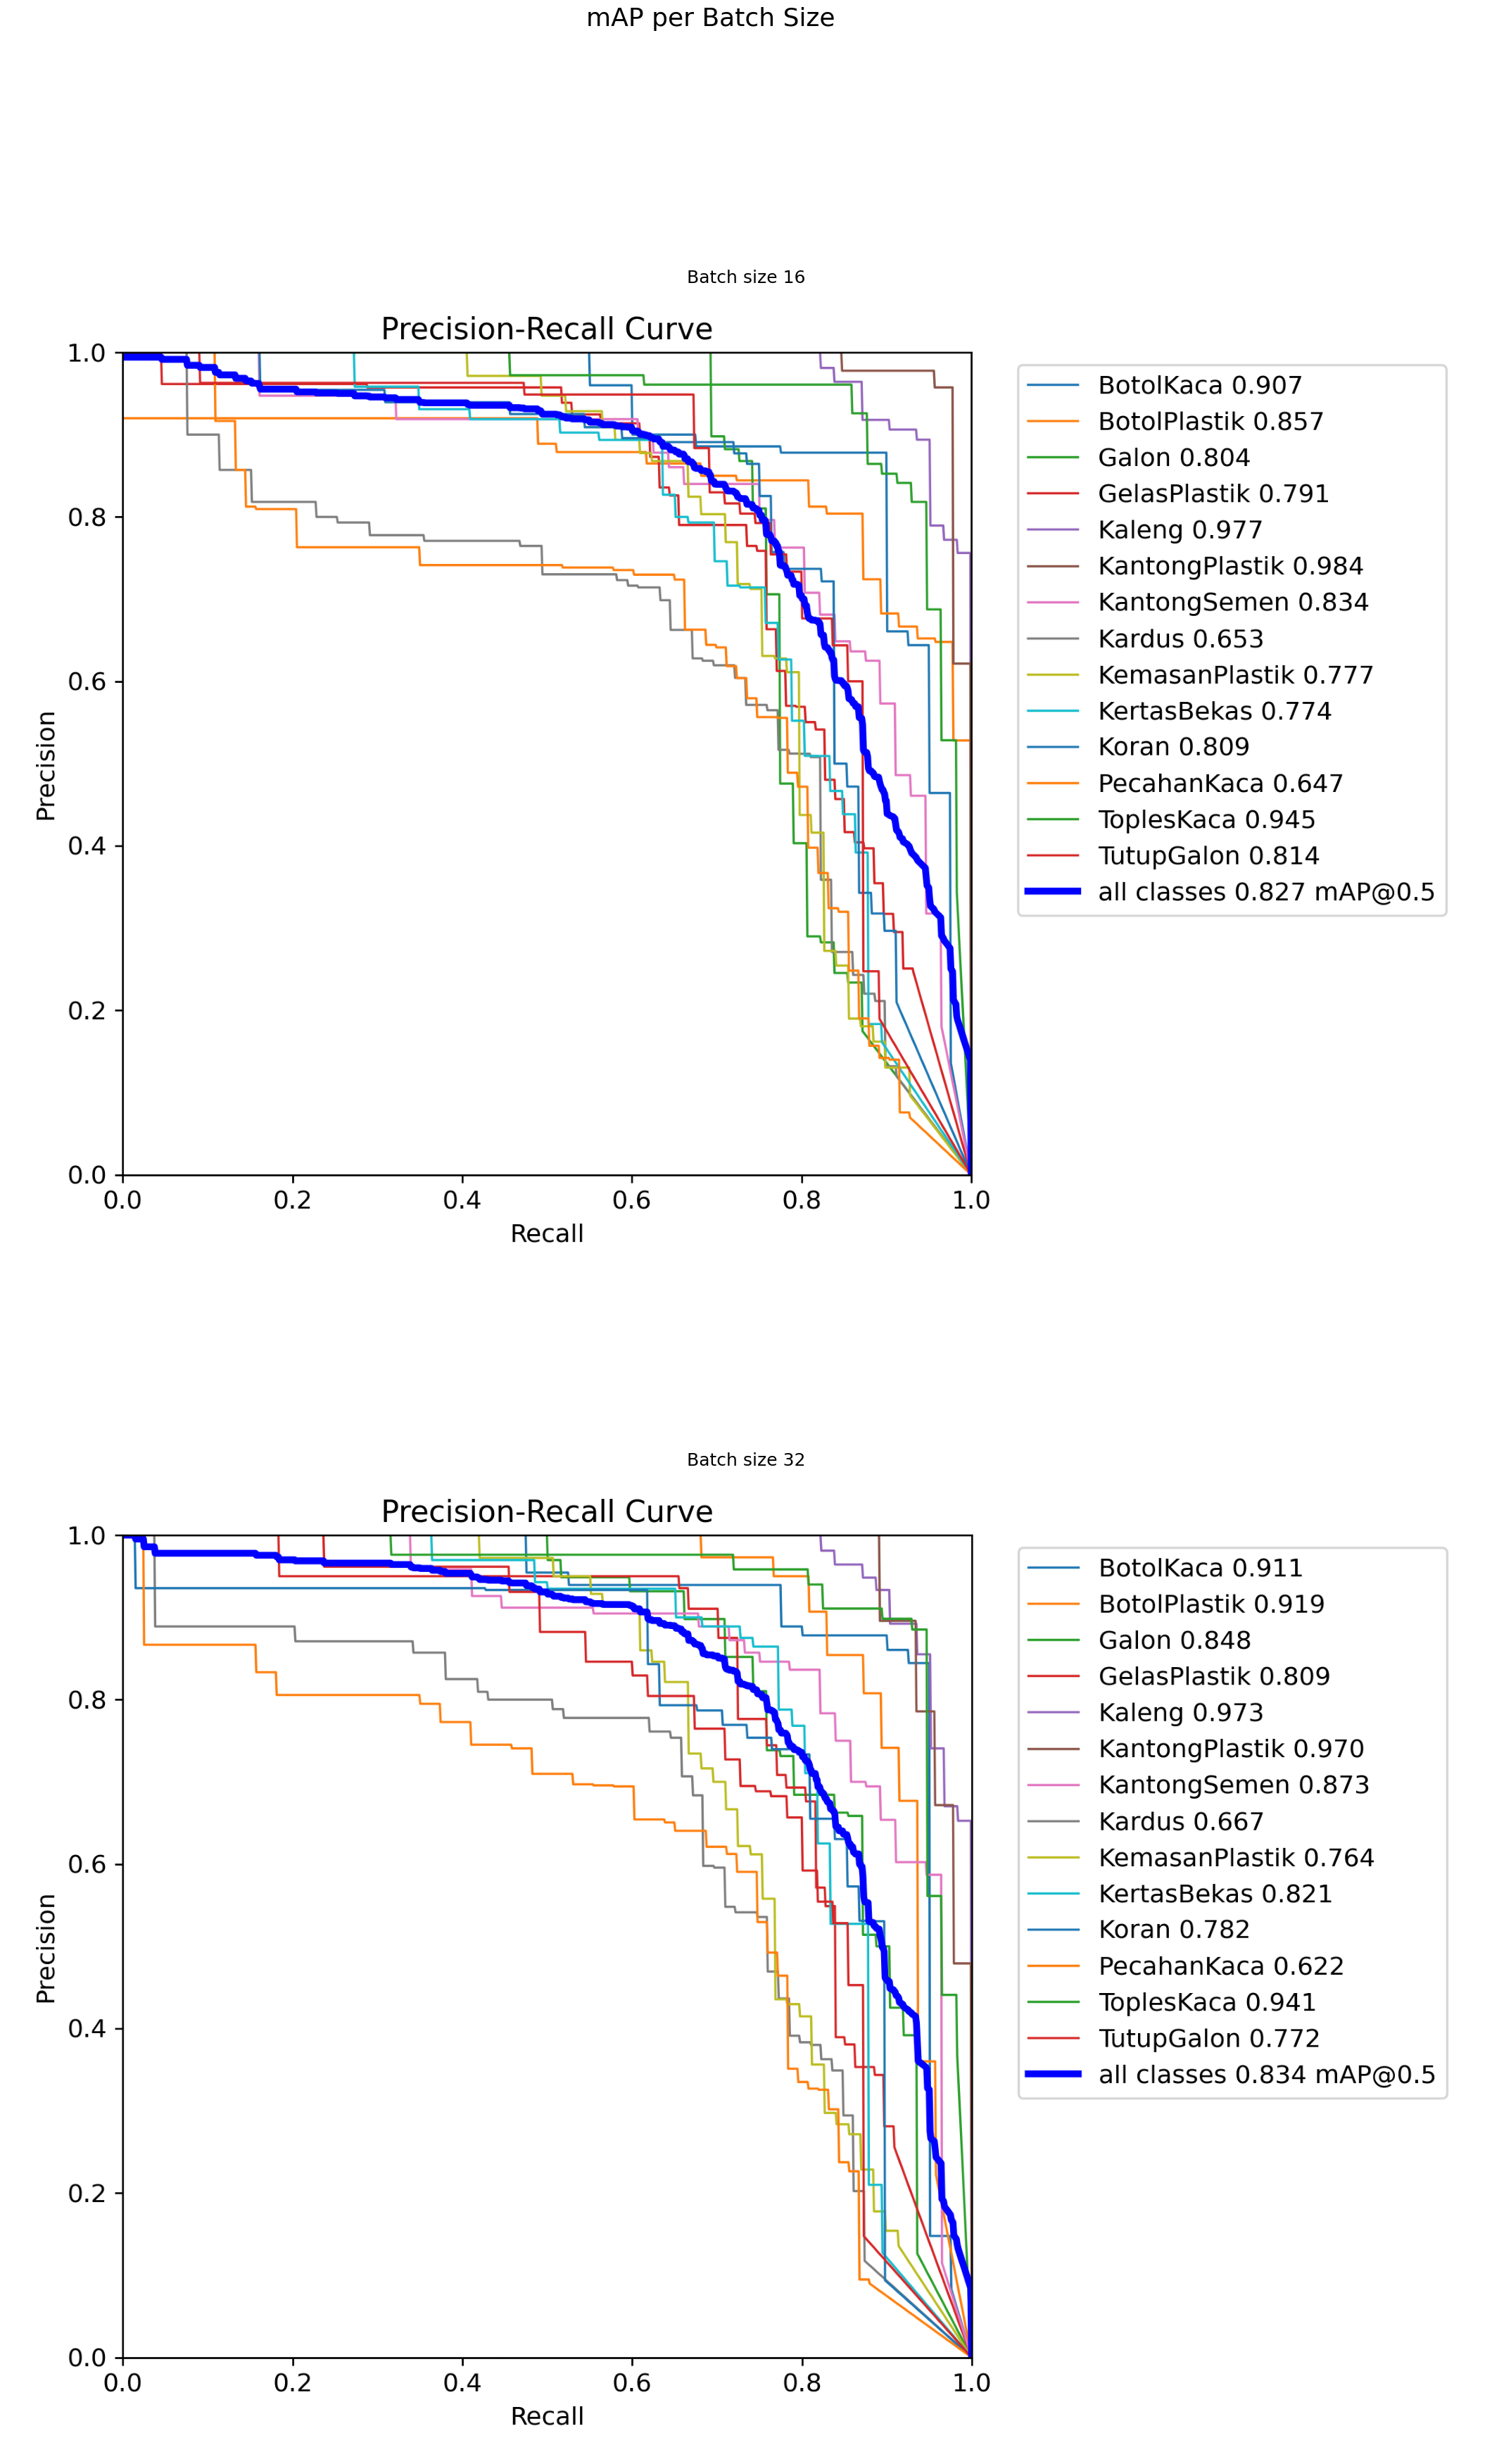

In [12]:
image_paths = [
    "/notebooks/runs/detect/yolov8s_e100_lr0.0001/PR_curve.png",
    "/notebooks/runs/detect/yolov8s_e100_lr0.0001_32/PR_curve.png"
]

images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
    else:
        print(f"Failed to load image at: {path}")
    
titles = ["Batch size 16", "Batch size 32"]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(40,40)) 

for i, img in enumerate(images):
    if img is not None:
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(rgb_image)
        axes[i].axis('off')
        axes[i].set_title(titles[i], fontsize=18)
    else:
        axes[i].text(0.5, 0.5, 'Image not loaded', fontsize=18, ha='center')
        axes[i].axis('off')

plt.suptitle("mAP per Batch Size", fontsize=26)
plt.show()

**BATCH SIZE 16**
metrics/precision(B): 0.8243484811814713
metrics/recall(B): 0.7706257971202667
metrics/mAP50(B): 0.8249441380862146
metrics/mAP50-95(B): 0.7291960375619259
fitness: 0.7387708476143547

**BATCH SIZE 32**
metrics/precision(B): 0.802956853840621
metrics/recall(B): 0.7906381276548784
metrics/mAP50(B): 0.8337436196823481
metrics/mAP50-95(B): 0.7341946226984812
fitness: 0.7441495223968679

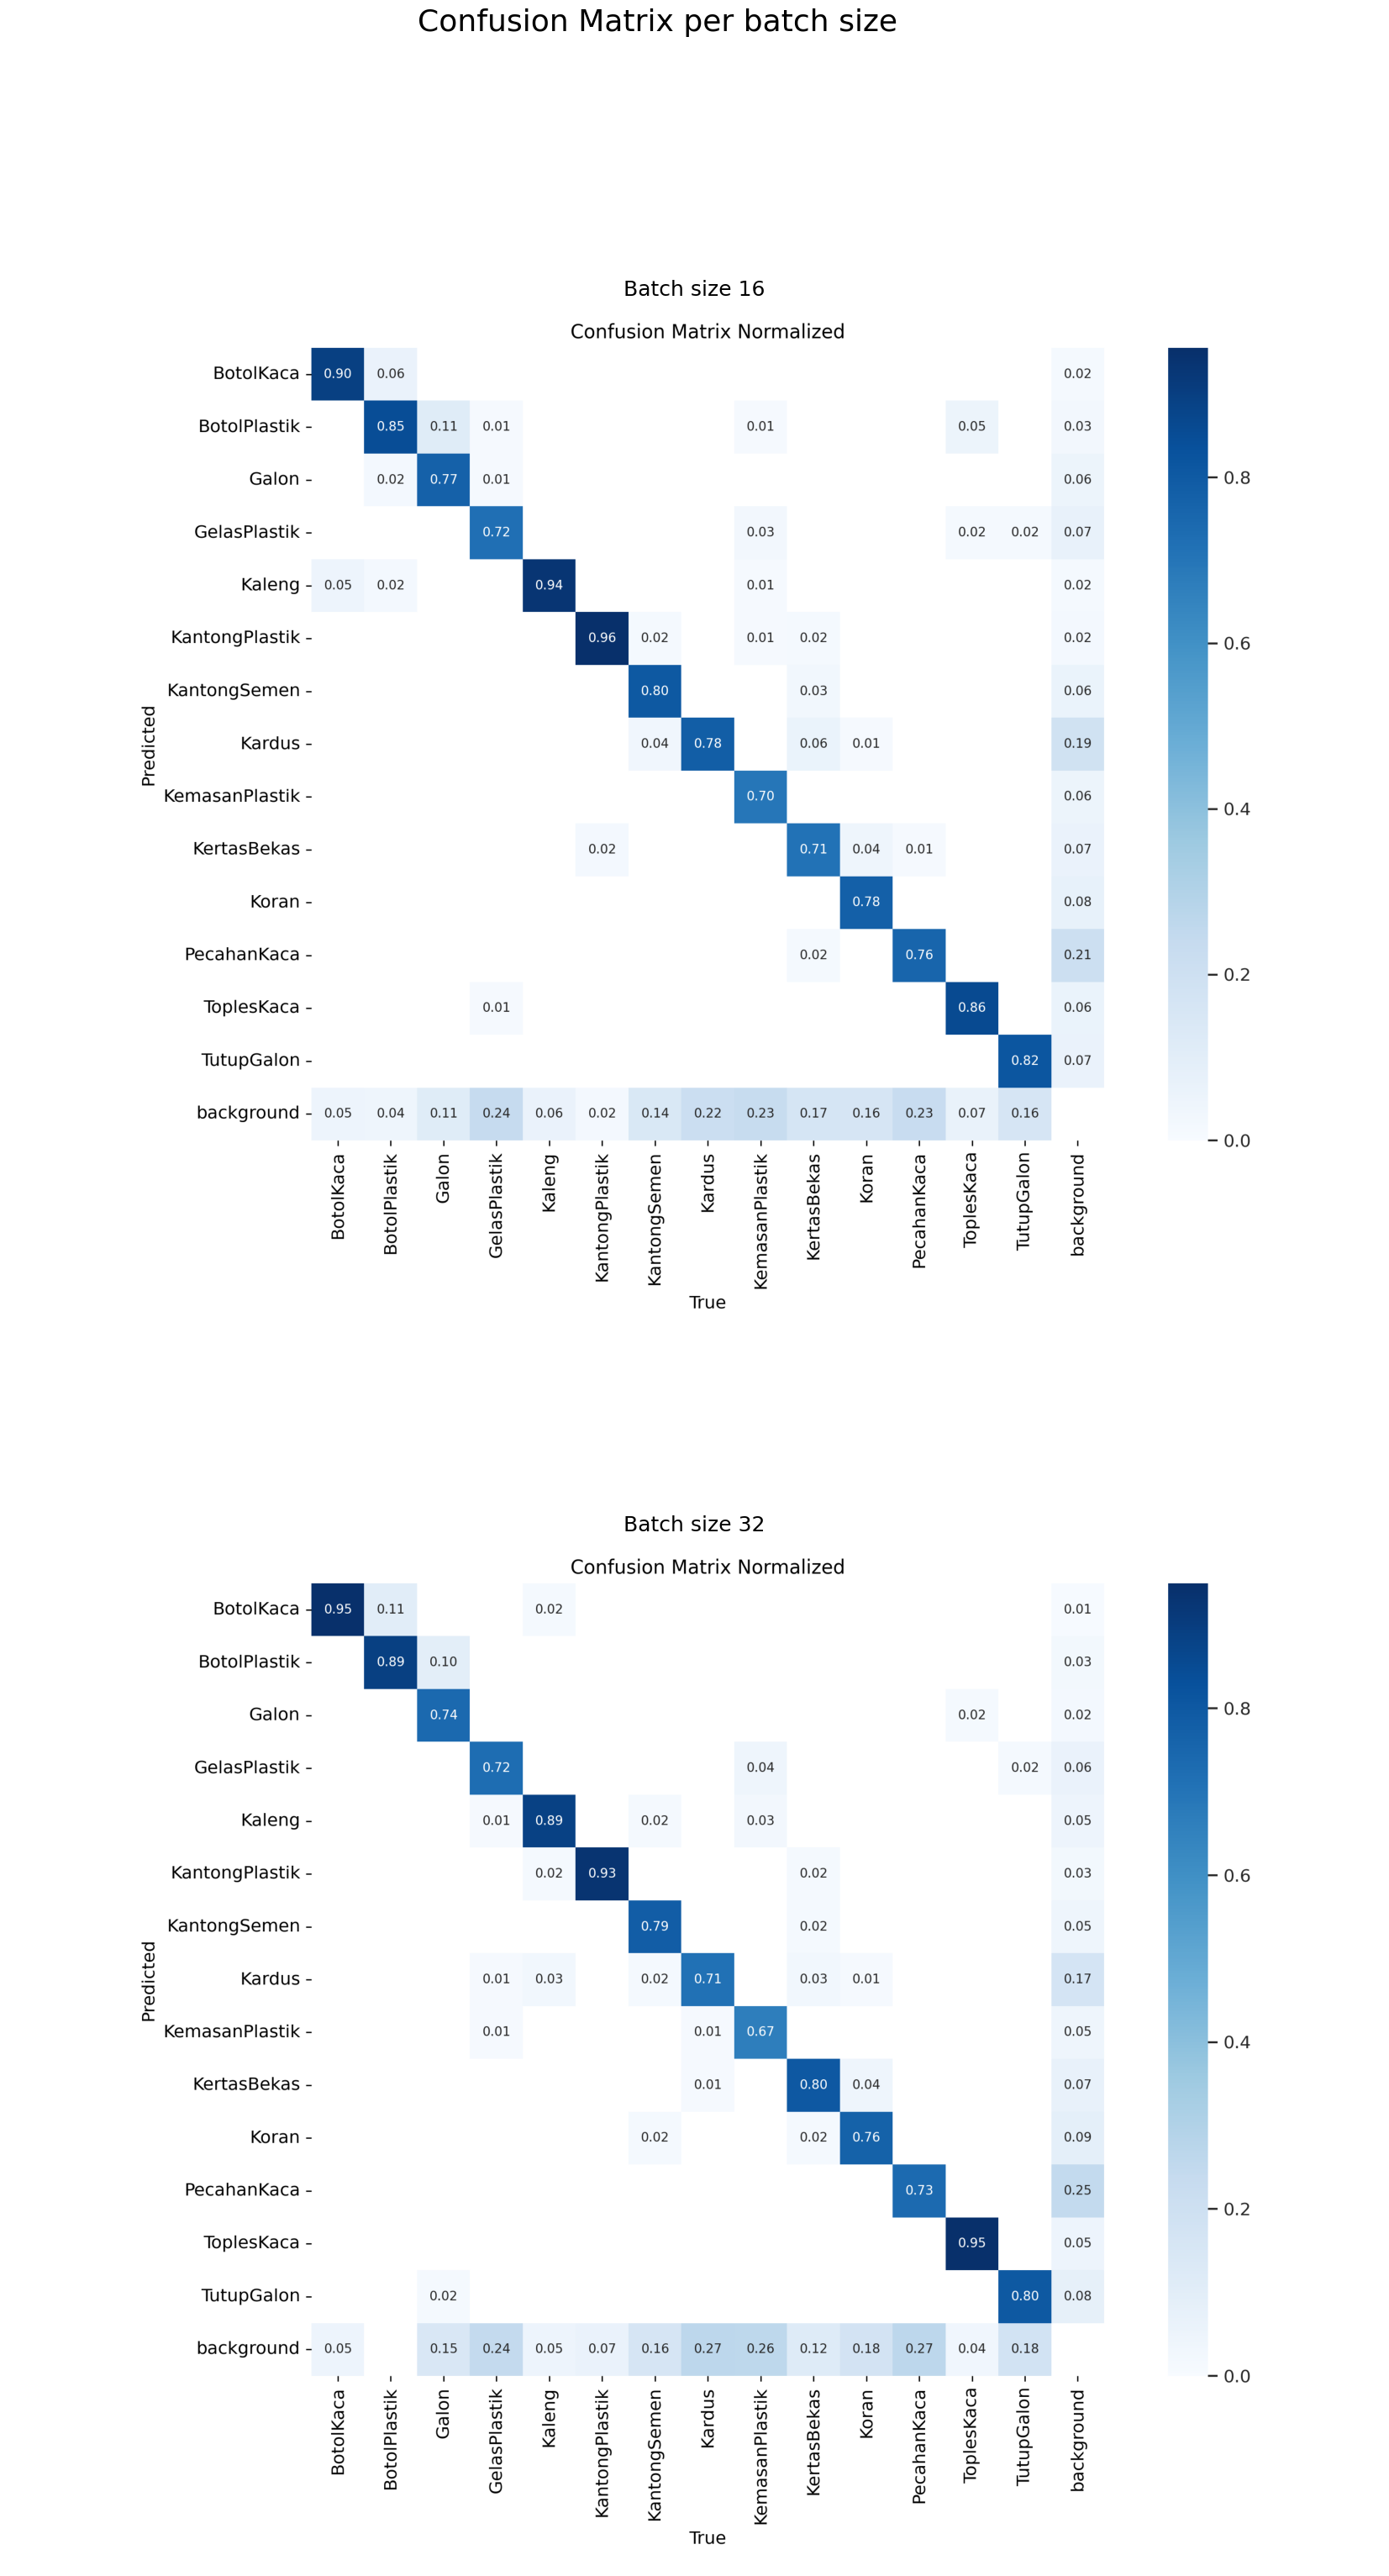

In [13]:
images = [cv2.imread(f) for f in [ "/notebooks/runs/detect/yolov8s_e100_lr0.0001/confusion_matrix_normalized.png",
                                 "/notebooks/runs/detect/yolov8s_e100_lr0.0001_32/confusion_matrix_normalized.png"]]

titles = ["Batch size 16", "Batch size 32"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(35, 35))

# Tampilkan setiap gambar pada axes yang sesuai
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(titles[i], fontsize=18)

# Tambahkan judul utama
plt.suptitle("Confusion Matrix per batch size", fontsize=26)

plt.show()

# TEST MODEL 


0: 448x640 4 BotolPlastiks, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 BotolPlastiks, 1 Galon, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


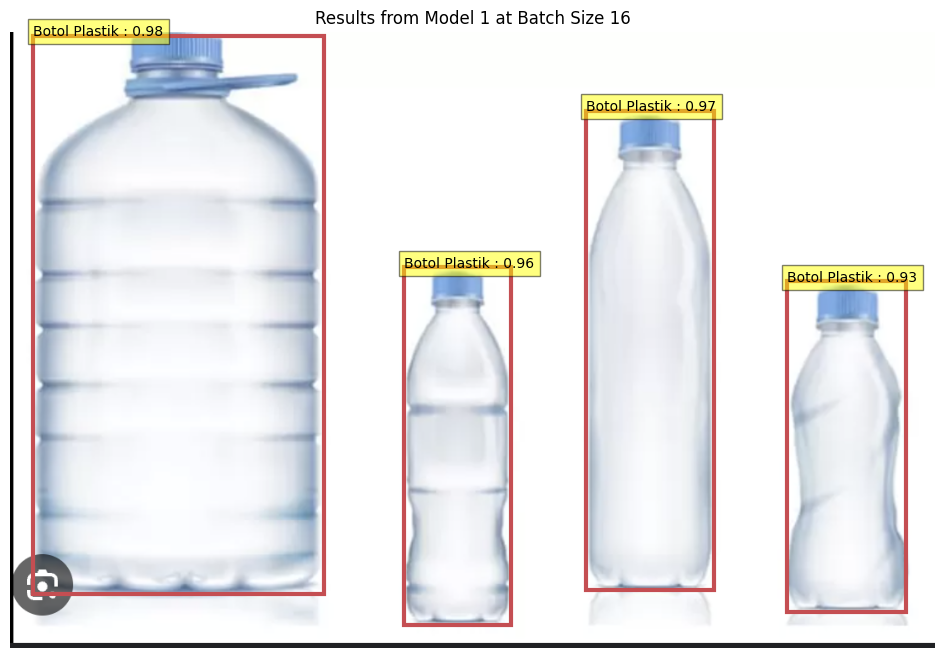

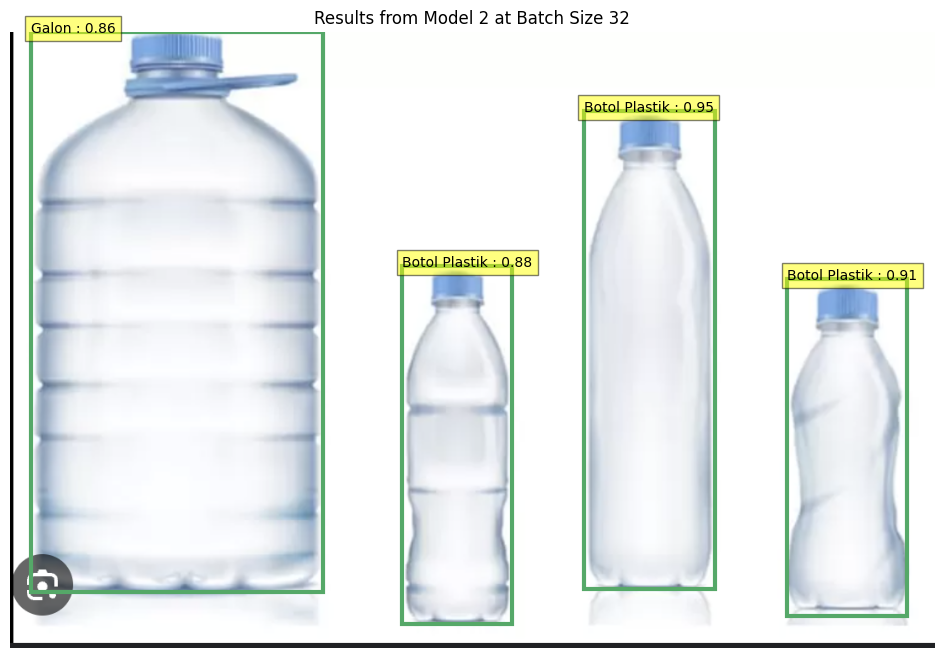

In [20]:

model1 = YOLO('/notebooks/models/yolov8s_e100_0.0001.pt')
model2 = YOLO('/notebooks/models/yolov8s_e100_0.0001_32.pt')

# Define the class names (assuming all models were trained on the same classes)
class_names = [
    'Botol Kaca', 'Botol Plastik', 'Galon', 'Gelas Plastik', 'Kaleng',
    'Kantong Plastik', 'Kantong Semen', 'Kardus', 'Kemasan Plastik',
    'Kertas Bekas', 'Koran', 'Pecahan Kaca', 'Toples Kaca', 'Tutup Galon'
]

# Function to load an image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

# Load your image
image_path = '/notebooks/botol dan galon.png'  # Update with the path to your image
original_image = load_image(image_path)

def plot_predictions(image, results, color, title):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()
        score = result.conf[0].cpu().numpy()
        label = class_names[int(result.cls[0].cpu().numpy())]
        if score > 0.5:
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{label} : {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.title(title)
    plt.show()

# Perform detection with each model
results1 = model1(original_image)
results2 = model2(original_image)

plot_predictions(original_image, results1, 'r', "Results from Model 1 at Batch Size 16")
plot_predictions(original_image, results2, 'g', "Results from Model 2 at Batch Size 32")

# SAVE MODEL YOLOv8s

In [17]:
import os

# Define old and new paths
old_paths = [
            '/notebooks/runs/detect/yolov8s_e100_lr0.0001_32/weights/best.pt'
]
new_directory = '/notebooks/models'
new_names = [
    'yolov8s_e100_0.0001_32.pt'
]

# Create the new directory if it doesn't exist
os.makedirs(new_directory, exist_ok=True)

# Move and rename the models
for old_path, new_name in zip(old_paths, new_names):
    new_path = os.path.join(new_directory, new_name)
    os.rename(old_path, new_path)